## Introduction
In this competition, The goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. 

## Dataset
For this competition, we will be using the popular MNIST database. It is a collection of 70.000 handwritten digits split into training and test set of 42.000 and 28.000 images respectively.

## Setting up the Environment
We will be using PyTorch to train a convolutional neural network to recognize MNIST's handwritten digits.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

from PIL import Image
from sklearn.model_selection import train_test_split
import math
import copy
import time

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

#neural net imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

%matplotlib inline
print(torch.__version__)

1.2.0


## Preparing the Dataset

we'll define the hyperparameters we'll be using for the experiment. Here the number of epochs defines how many times we'll loop over the complete training dataset, while learning_rate is the hyperparameter for the optimizer we'll be using later on.

We read both training and test set into dataframe then we split our training dataset into train and valid dataset in order to train and test our model. Train/Valid ratio is 15%.

In [2]:
random_seed = 42
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

# Load the data
train_df = pd.read_csv("../input/digit-recognizer/train.csv")
test_df = pd.read_csv("../input/digit-recognizer/test.csv")

y = train_df["label"]
x = train_df.drop("label", axis = 1)

#Split training data into Train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.15, shuffle=True)

num_epoch = 25
batch_size_train = 32
batch_size_test = 32
learning_rate = 0.002
momentum = 0.9
log_interval = 100

In [3]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The training dataset has 28x28 = 784 dimensions features and a column of label. The test dataset has 784-D data. Next we'll define Custom Dataset in order to do convert to tensor, do some transitions abd process data in mini-batches. Dataset takes two dataframe data. 

In [4]:
#CustomDatasetFromDF
class MNISTDataset(Dataset):
    def __init__(self,  data, target, train=True, transform=None):
        """
        Args:
            csv_path (string): path to csv file
            transform: pytorch transforms for transforms and tensor conversion
        """
        self.train = train
        if self.train :
            self.data = data
            self.labels = np.asarray(target.iloc[:])
        else:
            self.data = data
            self.labels = None
        self.height = 28 # Height of image
        self.width = 28 # Width of image
        self.transform = transform

    def __getitem__(self, index):
        # Read each 784 pixels and reshape the 1D array ([784]) to 2D array ([28,28])
        img_as_np = np.asarray(self.data.iloc[index][0:]).reshape(self.height, self.width).astype('uint8')
        # Convert image from numpy array to PIL image, mode 'L' is for grayscale
        img_as_img = Image.fromarray(img_as_np)
        img_as_img = img_as_img.convert('L')
        img_as_tensor = img_as_img
        
        if self.train:
            single_image_label = self.labels[index]
        else:
            single_image_label = None
            
        # Transform image to tensor
        if self.transform is not None:
            img_as_tensor = self.transform(img_as_img)
        
        if self.train:
        # Return image and the label                
            return (img_as_tensor, single_image_label)
        else:
            return img_as_tensor
    
    def __len__(self):
        return len(self.data.index)

PyTorch DataLoaders are objects that act as Python generators. They supply data in chunks or batches while training and validation.  
Our loader will behave like an iterator, so we can loop over it and fetch a different mini-batch every time. For each 

### Data Augmentation
Data augmentation is a common deep learning technique where we modify images on the fly while training the neural network to see additional images flipped or rotated at different axes and angles. This usually results in better training performance since the network sees multiple views of the same image and has a better chance of identifying its class when minimizing the loss function.
We use following augmentation:
* RandomRotation at a specific degree (15 in our case below) that rotates some of them randomly at an angle of 15 degree again with a probability of p which defaults to 0.5.

### Data Normalization
In data normalization, we statistically normalize the pixel values in our images. This mostly results in better training performance and faster convergence. A common way to perform normalization is to subtract the mean of pixel values of the whole dataset from each pixel, and then divide by the standard deviation of the pixels of the whole dataset.

The values 0.1310 and 0.3085 used for the Normalize() transformation below are the global mean and standard deviation of the MNIST dataset. Following code is used to calculate mean/std dev of dataset. It take dataloader as input.


In [5]:
def calculate_img_stats_full(dataset):
    imgs_ = torch.stack([img for img,_ in dataset],dim=1)
    imgs_ = imgs_.view(1,-1)
    imgs_mean = imgs_.mean(dim=1)
    imgs_std = imgs_.std(dim=1)
    return imgs_mean,imgs_std

#transformations_org = transforms.Compose([transforms.ToTensor()])
#train_org = MNISTDataset(x, y, True, transformations_org)

#calculate_img_stats_full(train_org)
# (tensor([0.1310]), tensor([0.3085]))

Now we can create our datasets again from scratch with all the transformations, augmentations, and normalization applied—splitting them into train and validation, and obtaining the final DataLoaders.

In [6]:
transformations_train = transforms.Compose([transforms.RandomRotation(15),                                       
                                            transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                            transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1310], std=[0.3085])
                                           ])


transformations_valid = transforms.Compose([transforms.ToTensor(),
                                            transforms.Normalize(mean=[0.1310], std=[0.3085])
                                           ])

train = MNISTDataset(X_train, y_train, True, transformations_train)
valid = MNISTDataset(X_valid, y_valid, True, transformations_valid)
test  = MNISTDataset(data=test_df, target=None, train=False, transform=transformations_valid)

In [7]:
train_loader = DataLoader(train, batch_size=batch_size_train,num_workers=2, shuffle=True)
valid_loader = DataLoader(valid, batch_size=batch_size_test, num_workers=2, shuffle=True)
test_loader  = DataLoader(test,  batch_size=batch_size_test, shuffle=False)

## Building the Network

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )
        
        self.linear_block = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128*7*7, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x

## Training the Model

In [16]:
cnn_model = Net()    
criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    cnn_model.cuda()
    criterion.cuda()                       

optimizer = optim.Adam(params=cnn_model.parameters(), lr=learning_rate)    

exp_lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min')

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(1, num_epoch + 1)]    

best_model_wts = copy.deepcopy(cnn_model.state_dict())
best_acc = 0.0

since = time.time()

for epoch in range(1, num_epoch + 1):
    cnn_model.train()    
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        # Clear gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = cnn_model(images)
        # Calculate loss
        loss = criterion(outputs, labels)
        # Backward pass
        loss.backward()
        # Update weights
        optimizer.step()
        if (i + 1)% log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i + 1) * len(images), len(train_loader.dataset),
                100. * (i + 1) / len(train_loader), loss.data))
            train_losses.append(loss.item())
            train_counter.append((i*64) + ((epoch-1)*len(train_loader.dataset)))
    cnn_model.eval()    
    loss = 0    
    running_corrects = 0
    with torch.no_grad():       
        for i, (data, target) in enumerate(valid_loader):
            data = Variable(data).cuda()
            target = Variable(target).cuda()
            output = cnn_model(data)
            loss += F.cross_entropy(output, target, reduction='sum').item()            
            _, preds = torch.max(output, 1)            
            running_corrects += torch.sum(preds == target.data)
    loss /= len(valid_loader.dataset)
    test_losses.append(loss)
    epoch_acc = 100. * running_corrects.double() / len(valid_loader.dataset)
    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, running_corrects, len(valid_loader.dataset), epoch_acc))
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(cnn_model.state_dict())
    exp_lr_scheduler.step(loss)
             
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_acc))

Train Epoch: 1 [3200/35700 (9%)]	Loss: 0.722314
Train Epoch: 1 [6400/35700 (18%)]	Loss: 0.652657
Train Epoch: 1 [9600/35700 (27%)]	Loss: 0.696196
Train Epoch: 1 [12800/35700 (36%)]	Loss: 0.445753
Train Epoch: 1 [16000/35700 (45%)]	Loss: 0.258333
Train Epoch: 1 [19200/35700 (54%)]	Loss: 0.271636
Train Epoch: 1 [22400/35700 (63%)]	Loss: 0.339841
Train Epoch: 1 [25600/35700 (72%)]	Loss: 0.243227
Train Epoch: 1 [28800/35700 (81%)]	Loss: 0.503460
Train Epoch: 1 [32000/35700 (90%)]	Loss: 0.214893
Train Epoch: 1 [35200/35700 (99%)]	Loss: 0.323193

Average Val Loss: 0.0654, Val Accuracy: 6172/6300 (97.968%)

Training complete in 0m 33s
Best val Acc: 97.968254


## Evaluating the Model's Performance

Text(0, 0.5, 'negative log likelihood loss')

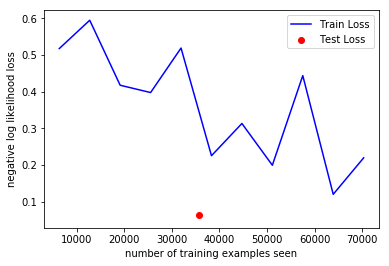

In [10]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

## Test the Model

In [11]:
cnn_model.eval()
test_preds = None
test_preds = torch.LongTensor()
    
for i, data in enumerate(test_loader):
    data = Variable(data).cuda()   
    output = cnn_model(data)
    preds = output.cpu().data.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, preds), dim=0)


In [12]:
out_df = pd.DataFrame({'ImageId':np.arange(1, len(test_loader.dataset)+1), 'Label':test_preds.numpy().squeeze()})
out_df.to_csv('submission.csv', index=False)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 